In [1]:
import requests
import numpy as np
import h5py
import matplotlib.pyplot as plt

import MAS_library as pylians_MASL
import smoothing_library as pylians_SL



%matplotlib inline

baseUrl = 'http://www.tng-project.org/api/'
headers = {"api-key":"9af02c30810f12be44f17ad2bd4b6510"}

sim_name = 'TNG100-1-Dark'
redshift = 0.0
base_query = f'/api/{sim_name}/snapshots/z={redshift}/'

def get(path, params=None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string

    return r



# Counting haloes for a list of conditions

In [2]:
# first convert log solar masses into group catalog units
mass_min = 10**11 / 1e10 * 0.704
mass_max = 10**15 / 1e10 * 0.704

# form the search_query string by hand for once
search_query = "?mass__gt=" + str(mass_min) + "&mass__lt=" + str(mass_max) +'&primary_flag__gt=0.9'+'&len__gr=150'

url = 'http://www.tng-project.org/api/TNG100-1-Dark/snapshots/z=0.0/'+"subhalos/" + search_query
subhalos = get(url, {'limit':20000})
print(f"{subhalos['count']} halos with search criteria \n \t {search_query}")



#get random 10 halos
np.random.seed(0)

random_idx = np.random.choice(subhalos['count'], 3, replace=False)

subhalos = [subhalos['results'][i] for i in random_idx]

subhalos = {sh['id']:sh['url'] for sh in subhalos}


16544 halos with search criteria 
 	 ?mass__gt=7.039999999999999&mass__lt=70400.0&primary_flag__gt=0.9&len__gr=150


In [3]:
import astropy.cosmology
from astropy import units as u
from astropy import constants as const

sim = get('http://www.tng-project.org/api/TNG100-1-Dark')
snapshot = get('http://www.tng-project.org/api/TNG100-1-Dark/snapshots/z=0.0/')


z = snapshot['redshift']
Omega_0 = sim['omega_0']
omega_B = sim['omega_B']
h = sim['hubble']

dm_mass = sim['mass_dm']


cosmo = astropy.cosmology.FlatLambdaCDM(H0=h*100, Om0=Omega_0, Ob0=omega_B) #also astropy.cosmology.Planck15 but its a bit different
#mean_density = cosmo.critical_density(z).to('Msun/Mpc^3').value
mean_density = cosmo.critical_density(z)

In [4]:
import MAS_library as pylians_MASL
import smoothing_library as pylians_SL

---

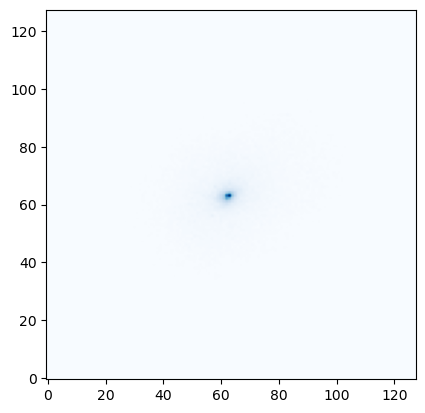

In [18]:
cutout = 'cutout_818916.hdf5'
f =  h5py.File(cutout,'r')

x = f['PartType1']['Coordinates'][:,0]
y = f['PartType1']['Coordinates'][:,1]
z = f['PartType1']['Coordinates'][:,2]

center = np.array([np.mean(x), np.mean(y), np.mean(z)])

x = x - center[0]
y = y - center[1]
z = z - center[2]

max_size = np.max([np.max(x) - np.min(x), np.max(y) - np.min(y), np.max(z) - np.min(z)])
max_size = max_size

grid_size = 128

pos = np.array([x, y, z]).T

hist, bins = np.histogramdd(pos, bins=grid_size, range=[[-max_size/2, max_size/2], [-max_size/2, max_size/2], [-max_size/2, max_size/2]])


plt.imshow(hist.sum(axis=2), origin='lower', cmap='Blues')

In [19]:
#i_test = grid_size//2 +1
#j_test = grid_size//2  
#z_test = grid_size//2-2


argmax = np.unravel_index(hist.argmax(), hist.shape)
i_test = argmax[0]
j_test = argmax[1]
z_test = argmax[2]

#i_test = 63 #np.unravel_index(hist.argmax(), hist.shape)
#j_test = 63
#z_test = 68 

test_xmin, test_xmax = bins[0][i_test],bins[0][i_test+1]
test_ymin, test_ymax = bins[1][j_test],bins[1][j_test+1]
test_zmin, test_zmax = bins[2][z_test],bins[2][z_test+1]

test_hist = hist[i_test, j_test, z_test]

test_count = np.sum( (x > test_xmin) & (x < test_xmax) & (y > test_ymin) & (y < test_ymax) & (z > test_zmin) & (z < test_zmax) )

print(test_hist, test_count)

344.0 344



Using CIC mass assignment scheme
Time taken = 0.003 seconds

200.68294 37524.01 37478.0 37524


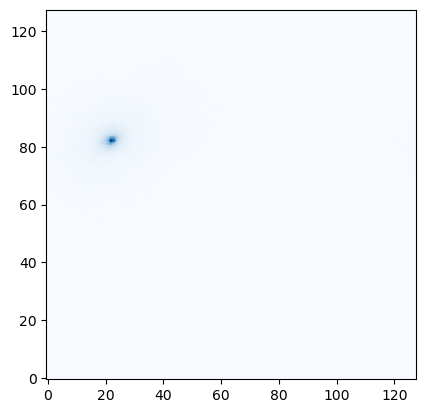

In [35]:
#pos_f32 = pos.astype(np.float32)

pos_f32 = pos + center
pos_f32 = pos_f32.astype(np.float32)

counts = np.zeros((grid_size,grid_size,grid_size), dtype=np.float32)

pylians_MASL.MA(pos_f32, counts, max_size, "CIC", verbose=True)


print(np.max(counts), np.sum(counts), np.sum(hist), len(x))

plt.imshow(counts.sum(axis=2), origin='lower', cmap='Blues')



In [ ]:
cutout = 'cutout_818916.hdf5'
#with h5py.File(cutout,'r') as f:
f =  h5py.File(cutout,'r')

x = f['PartType1']['Coordinates'][:,0]
y = f['PartType1']['Coordinates'][:,1]
z = f['PartType1']['Coordinates'][:,2]

grid_size = 128

pos = np.array([x,y,z]).T
pos = pos.astype(np.float32)

density = np.zeros((grid_size,grid_size,grid_size), dtype=np.float32)

boxsize = f['Header'].attrs['BoxSize']/1e3

pylians_MASL.MA(pos, density, boxsize, "CIC", verbose=True)


print(np.sum(density)/len(x))
plt.imshow(density.sum(axis=0), cmap='Blues')

In [ ]:
hist = np.histogramdd(pos, bins=grid_size, range=[[0,boxsize],[0,boxsize],[0,boxsize]])

In [ ]:
hist[0].shape

In [ ]:
hist[0].sum()

In [ ]:
plt.imshow(hist[0].sum(axis=0), cmap='Blues')

In [ ]:
np.mean(x), np.mean(y), np.mean(z)

In [ ]:
np.max(density.sum(axis=0))

In [ ]:
np.mean(density)

In [ ]:
np.sum(density)

In [ ]:
#def get_dm(id):
cutout = 'cutout_818916.hdf5'
with h5py.File(cutout,'r') as f:

    # slice_2d = None
    # assert slice_2d is None or slice_2d=='xy' or slice_2d=='xz' or slice_2d=='yz', "slice_2d must be None, 'xy', 'xz' or 'yz'"

    # #pylians3 https://pylians3.readthedocs.io/en/master/construction.html

    # id = 818916
    # url = subhalos[id]
    # sub_prog = get(url)

    # cutout_request = {'dm':'Coordinates,SubfindDMDensity'}
    # cutout = get(url+"cutout.hdf5", cutout_request)


    #file attributes: https://www.tng-project.org/data/docs/specifications/

    #center coord
    #center = np.array([sub_prog['pos_x'], sub_prog['pos_y'], sub_prog['pos_z']])


    x = f['PartType1']['Coordinates'][:,0]
    y = f['PartType1']['Coordinates'][:,1]
    z = f['PartType1']['Coordinates'][:,2]

    #displacement vector 
    disp = np.array([np.min(x), np.min(y), np.min(z)]).astype(np.float32)


    
    #dm_mass = f['Header'].attrs['MassTable'][1] * 1e10 #Msun/h

    Np = len(x)

    grid = 128
    BoxSize = f['Header'].attrs['BoxSize'] #kpc/h
    #BoxSize = 128
    #BoxSize = 1
    MAS = 'CIC'
    verbose = True

    pos = np.array([x,y,z]).T
    pos = pos - disp

    #pos normalized to 1
    pos[:,0] = pos[:,0]/np.max(pos[:,0])
    pos[:,1] = pos[:,1]/np.max(pos[:,1])
    pos[:,2] = pos[:,2]/np.max(pos[:,2])

    pos = pos*BoxSize

    delta = np.zeros((grid,grid,grid), dtype=np.float32)

    pos = pos.astype(np.float32)
    delta = delta.astype(np.float32)

    #add center vector to pos Np*1 times (concatenate)
    #pos = np.concatenate((pos, np.tile(center, (Np,1))), axis=1)


    pylians_MASL.MA(pos, delta, BoxSize, MAS, verbose=verbose)

    #delta = delta/np.mean(delta, dtype=np.float64) - 1.0


    R = 10 #kpc/h
    Filter = 'Gaussian'
    threads = 28

    W_k = pylians_SL.FT_filter(BoxSize, R, grid, Filter, threads)

    delta_smoothed = pylians_SL.field_smoothing(delta, W_k, threads)

    

In [ ]:
grid

In [ ]:
np.argmax(delta)

In [ ]:
delta.shape

In [ ]:
# from mayavi import mlab

# # Plot scatter with mayavi
# figure = mlab.figure('DensityPlot')

# grid_arr = np.arange(grid)
# grid = mlab.pipeline.scalar_field(delta)
# min = delta.min()
# max=delta.max()
# mlab.pipeline.volume(grid, vmin=min, vmax=min + .5*(max-min))

# mlab.axes()
# mlab.show()

In [ ]:
plt.plot(pos[:,0], pos[:,1], 'o', markersize=1)

In [ ]:
plt.imshow(delta.sum(axis = 1))
plt.colorbar()
plt.figure()
plt.imshow(np.log10(delta.sum(axis = 1)), cmap='inferno')
plt.colorbar()

In [ ]:
plt.imshow(delta_smoothed.sum(axis = 1))
plt.colorbar()
plt.figure()
plt.imshow(np.log10(delta_smoothed.sum(axis = 1)), cmap='inferno')
plt.colorbar()

In [ ]:
plt.imshow(delta.sum(axis = 2))
plt.colorbar()

In [ ]:
import numpy as np
import MAS_library as MASL
%matplotlib inline
# number of particles
Np = 256**2

# density field parameters
grid    = 256    #the 2D field will have grid x grid pixels
BoxSize = 1000.0 #Mpc/h ; size of box
MAS     = 'TSC'  #mass-assigment scheme
verbose = True   #print information on progress

# particle positions in 2D
pos = np.random.random((Np,2)).astype(np.float32)*BoxSize
#pos = np.random.normal(0, 1, (Np,2)).astype(np.float32)*BoxSize

# define 2D density field
delta = np.zeros((grid,grid), dtype=np.float32)

# construct 2D density field
MASL.MA(pos, delta, BoxSize, MAS, verbose=verbose)

# at this point, delta contains the effective number of particles in each pixel
# now compute overdensity and density constrast
#delta /= np.mean(delta, dtype=np.float64);  delta -= 1.0


plt.imshow(delta)

In [ ]:
plt.plot(pos[:, 0], pos[:, 1], 'k.', markersize=1)